# Árboles de Clasificación

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

In [3]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='UniqueCarrier',outputCol='IndexUniqueCarrier') #el índice empieza en el 0!
bd6=indexer.fit(bd5).transform(bd5)

bd6.groupBy('UniqueCarrier','IndexUniqueCarrier').count().sort('IndexUniqueCarrier').show()


+-------------+------------------+-----+
|UniqueCarrier|IndexUniqueCarrier|count|
+-------------+------------------+-----+
|           AA|               0.0| 8853|
|           UA|               1.0| 6112|
|           WN|               2.0| 5395|
|           DL|               3.0| 4239|
|           VX|               4.0| 1703|
|           NK|               5.0| 1581|
|           F9|               6.0| 1295|
|           OO|               7.0| 1166|
|           B6|               8.0|  121|
|           EV|               9.0|    1|
+-------------+------------------+-----+



## Ajuste del modelo

In [4]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col

a1  = VectorAssembler(
    inputCols=['DepDelay','Distance','DayOfWeek',
               'CRSDepTime','IndexUniqueCarrier'],
    outputCol='features')

bd7 = a1.transform(bd6).select(col("Retraso").cast('double').alias("label"),'features')

stringIndexer = StringIndexer(inputCol = 'label', outputCol = 'label2')
sI = stringIndexer.fit(bd7)
bd7 = sI.transform(bd7)



### Partición Test - Train

In [5]:
(bd_train, bd_test) = bd7.randomSplit([0.7, 0.3],seed=123)
print(bd_train.count())
print(bd_test.count())

21334
9132


In [6]:
from pyspark.ml.classification import DecisionTreeClassifier as DTC

rt = DTC(maxDepth=5, labelCol = 'label2')

model = rt.fit(bd_train)
pred = model.transform(bd_train)

In [7]:
pred.show()

+-----+--------------------+------+--------------+--------------------+----------+
|label|            features|label2| rawPrediction|         probability|prediction|
+-----+--------------------+------+--------------+--------------------+----------+
|  0.0|[-21.0,868.0,6.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|
|  0.0|[-17.0,888.0,7.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|
|  0.0|[-17.0,1440.0,1.0...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|
|  0.0|[-17.0,1744.0,1.0...|   0.0| [923.0,114.0]|[0.89006750241080...|       0.0|
|  0.0|[-16.0,641.0,6.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|
|  0.0|[-16.0,888.0,3.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|
|  0.0|[-15.0,731.0,4.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|
|  0.0|[-15.0,868.0,3.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|
|  0.0|[-15.0,888.0,4.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|
|  0

In [8]:
pred.groupBy('probability').count().show(50)


+--------------------+-----+
|         probability|count|
+--------------------+-----+
|[0.89006750241080...| 1037|
|[0.19105691056910...|  246|
|[0.37651821862348...|  247|
|[0.73431734317343...| 1084|
|[0.45070422535211...|  426|
|       [0.075,0.925]|   40|
|[0.72289156626506...|   83|
|[0.03358208955223...|  268|
|[0.35714285714285...|   56|
|[0.16049382716049...|   81|
|           [0.0,1.0]| 2492|
|[0.89127218934911...| 1352|
|[0.56684491978609...|  374|
|[0.89622641509433...|  106|
|           [0.5,0.5]|   38|
|[0.00297619047619...|  336|
|[0.93023255813953...| 2494|
|[0.09821428571428...|  112|
|[0.68695652173913...|  115|
|[0.96551724137931...|   29|
|[0.96120920278223...| 7476|
|[0.79834254143646...|  362|
|[0.94207096307023...| 1381|
|[0.71111111111111...|   45|
|[0.23376623376623...|   77|
|[0.24193548387096...|   62|
|         [0.05,0.95]|   40|
|[0.03703703703703...|  216|
|[0.83218390804597...|  435|
|[0.54910714285714...|  224|
+--------------------+-----+



In [9]:
pred.groupBy('label','prediction').count().show()
#threshold = 0.5

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 4267|
|  0.0|       0.0|15030|
|  0.0|       1.0|  432|
|  1.0|       0.0| 1605|
+-----+----------+-----+



### Curva ROC

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

secondelement=udf(lambda v:float(v[1]),FloatType())
pred2=pred.withColumn('probs',secondelement('probability'))

pred2.show(10)

+-----+--------------------+------+--------------+--------------------+----------+-----------+
|label|            features|label2| rawPrediction|         probability|prediction|      probs|
+-----+--------------------+------+--------------+--------------------+----------+-----------+
|  0.0|[-21.0,868.0,6.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|0.038790796|
|  0.0|[-17.0,888.0,7.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|0.038790796|
|  0.0|[-17.0,1440.0,1.0...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|0.038790796|
|  0.0|[-17.0,1744.0,1.0...|   0.0| [923.0,114.0]|[0.89006750241080...|       0.0|  0.1099325|
|  0.0|[-16.0,641.0,6.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|0.038790796|
|  0.0|[-16.0,888.0,3.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|0.038790796|
|  0.0|[-15.0,731.0,4.0,...|   0.0|[7186.0,290.0]|[0.96120920278223...|       0.0|0.038790796|
|  0.0|[-15.0,868.0,3.0,...|   0.0|[7186.0,290.0]|

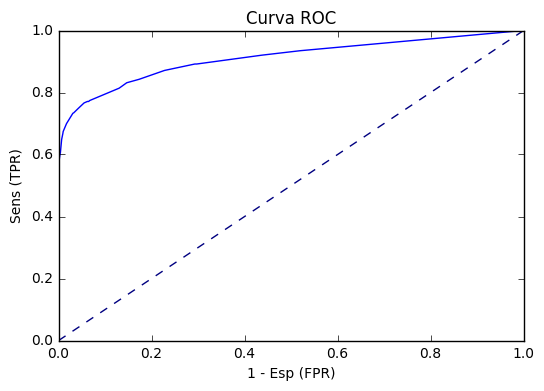

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns

pd5 = pred2.sample(False,0.1).select('label','probs').toPandas()

fpr, tpr, _ = roc_curve( pd5['label'], pd5['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('1 - Esp (FPR)')
plt.ylabel('Sens (TPR)')
plt.title('Curva ROC')
plt.show()

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))


AUC= 0.921873535127166


In [13]:
# DecisionTreeClassifier(featuresCol="features",
#    labelCol="label",
#    predictionCol="prediction",
#    probabilityCol="probability",
#    rawPredictionCol="rawPrediction",
#    maxDepth=5,
#    maxBins=32,
#    minInstancesPerNode=1,
#    minInfoGain=0.0,
#    maxMemoryInMB=256,
#    impurity="gini"  / impurity="entropy" )

In [14]:
rt = DTC(maxDepth=20, labelCol = 'label2')
model = rt.fit(bd_train)
pred = model.transform(bd_train)

print('AUC=',BCE(metricName="areaUnderROC", rawPredictionCol = 'probability').evaluate(pred))

AUC= 0.9995613642058918


### Validación externa

In [15]:
predtest = model.transform(bd_test)

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(predtest))

AUC= 0.8240007911857168
